In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

In [192]:
df = pd.read_csv('E:\\singapore\\data\\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df.tail(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
77892,2020-08,YISHUN,EXECUTIVE,724,YISHUN ST 71,07 TO 09,142.0,Apartment,1986,64 years 11 months,555000.0
77893,2020-08,YISHUN,EXECUTIVE,877,YISHUN ST 81,04 TO 06,145.0,Maisonette,1987,66 years 04 months,639888.0
77894,2020-08,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,01 TO 03,164.0,Multi Generation,1987,66 years 04 months,725000.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77895 entries, 0 to 77894
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                77895 non-null  object 
 1   town                 77895 non-null  object 
 2   flat_type            77895 non-null  object 
 3   block                77895 non-null  object 
 4   street_name          77895 non-null  object 
 5   storey_range         77895 non-null  object 
 6   floor_area_sqm       77895 non-null  float64
 7   flat_model           77895 non-null  object 
 8   lease_commence_date  77895 non-null  int64  
 9   remaining_lease      77895 non-null  object 
 10  resale_price         77895 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 6.5+ MB


In [2]:
# after geocoding on the internet, i get the data below:
data = pd.read_csv('E:\\singapore\\data\\all_geocoded.csv')
data_copy = data.copy()

In [3]:
data.head(3)

,month,town,flat_type,addresses,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,searchval,X,Y,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri
0,2018-01,ANG MO KIO,2 ROOM,314 ANG MO KIO AVE 3,10 TO 12,44.0,Improved,1978,59 years 01 month,250000.0,TECK GHEE EVERGREEN,29865.99805,38695.97027,1.366227,103.850086,416.686149,9162.186778,1396.420210
1,2018-01,ANG MO KIO,3 ROOM,109 ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,59 years 07 months,240000.0,KEBUN BARU HEIGHTS,28486.23758,39123.83010,1.370097,103.837688,1321.143682,9713.392312,552.239946
2,2018-01,ANG MO KIO,3 ROOM,150 ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,62 years,240000.0,YIO CHU KANG GROVE,28968.13327,39865.81646,1.376807,103.842018,640.152689,10391.930070,879.171242


**Simple handling**

In [4]:
# drop unnecessary features
data = data.drop(columns = ['X', 'Y', 'searchval'])

# 1.DATA PREPARATION


## 1.1.DATA CLEANING

1.1.1.String data

In [5]:
# convert "month" to datetime type served for observing change by time and splitting to train and test
data['month'] = pd.to_datetime(data['month']).dt.strftime('%Y-%m')

In [6]:
data['flat_type'].value_counts()
# => because number of data points of MULTI-GENERATION and 1 ROOM are too less => remove, removing will be implemented in 
# the below code

flat_type
4 ROOM              23629
5 ROOM              14304
3 ROOM              13820
EXECUTIVE            4590
2 ROOM                984
MULTI-GENERATION       31
1 ROOM                 28
Name: count, dtype: int64

In [7]:
data['flat_model'].value_counts()

flat_model
Model A                   19198
Improved                  14385
New Generation             7761
Premium Apartment          5958
Simplified                 2308
Apartment                  2306
Maisonette                 1744
Standard                   1584
DBSS                        953
Model A2                    729
Adjoined flat               118
Model A-Maisonette          100
Type S1                      90
Type S2                      48
Terrace                      31
Multi Generation             31
Premium Apartment Loft       23
Improved-Maisonette           9
Premium Maisonette            8
2-room                        2
Name: count, dtype: int64

In [8]:
data['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '16 TO 18', '22 TO 24', '19 TO 21', '28 TO 30', '25 TO 27',
       '34 TO 36', '31 TO 33', '40 TO 42', '37 TO 39', '46 TO 48',
       '49 TO 51', '43 TO 45'], dtype=object)

In [9]:
# categorize to group them into specific group for reducing dimensions
replace_values = {'NEW GENERATION':'New Generation', 'SIMPLIFIED':'Simplified', 'STANDARD':'Standard', 
                  'MODEL A-MAISONETTE':'Maisonette', 'MULTI GENERATION':'Multi Generation', 
                  'IMPROVED-MAISONETTE':'Executive Maisonette', 'Improved-Maisonette':'Executive Maisonette', 
                  'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'MODEL A':'Model A', 
                  'MAISONETTE':'Maisonette', 'Model A-Maisonette':'Maisonette', 'IMPROVED':'Improved', 
                  'TERRACE':'Terrace', 'PREMIUM APARTMENT':'Premium Apartment', 'Premium Apartment Loft':'Premium Apartment', 
                  'APARTMENT':'Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}

data = data.replace({'flat_model': replace_values})
data['flat_model'].value_counts()

flat_model
Model A                 19198
Improved                14385
New Generation           7761
Premium Apartment        5981
Simplified               2308
Apartment                2306
Maisonette               1844
Standard                 1584
DBSS                      953
Model A2                  729
Type S1S2                 138
Adjoined flat             118
Terrace                    31
Multi Generation           31
Executive Maisonette       17
2-room                      2
Name: count, dtype: int64

In [10]:
# label encode storeys
# because the storeys_range is by order, so i use it as ordinal values
category_mapping = {
    "01 TO 03": "A1",
    "04 TO 06": "A2",
    "07 TO 09": "B1",
    "10 TO 12": "B2",
    "13 TO 15": "B3",
    "16 TO 18": "C1",
    "19 TO 21": "C2",
    "22 TO 24": "C3",
    "25 TO 27": "C4",
    "28 TO 30": "D1",
    "31 TO 33": "D2",
    "34 TO 36": "D3",
    "37 TO 39": "D4",
    "40 TO 42": "D5",
    "43 TO 45": "D6",
    "46 TO 48": "D7",
    "49 TO 51": "D8"
}
data['storey_range'] = data['storey_range'].map(category_mapping)
data['storey_range'] = data['storey_range'].astype('category').cat.codes #convert to ordinal values 
# remove flat types with very few cases
data = data[~data['flat_type'].isin(['MULTI-GENERATION', '1 ROOM'])]
# Re-categorize flat model to reduce num classes (for reducing dimensions)
replace_values = {'Executive Maisonette':'Maisonette', 'Terrace':'Special', 'Adjoined flat':'Special', 
                    'Type S1S2':'Special', 'DBSS':'Special', 'Model A2':'Model A', 'Premium Apartment':'Apartment', 
                    'Improved':'Standard', 'Simplified':'Model A', '2-room':'Standard'}
data = data.replace({'flat_model': replace_values})
# Label encode flat type
replace_values = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
data = data.replace({'flat_type': replace_values})

In [11]:
data['flat_model'].value_counts()

flat_model
Model A           22235
Standard          15943
Apartment          8287
New Generation     7761
Maisonette         1861
Special            1240
Name: count, dtype: int64

In [12]:
#get dummy since the flat_model is not by order
data['flat_model'] = data['flat_model'].astype('object')
data = pd.get_dummies(data, columns=['flat_model'], prefix=['model'])

In [13]:
columns_to_convert = ['model_Apartment','model_Maisonette','model_Model A','model_New Generation',
                      'model_Special','model_Standard']
data[columns_to_convert] = data[columns_to_convert].astype(int)

In [14]:
data.head(1) #done string data

,month,town,flat_type,addresses,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard
0,2018-01,ANG MO KIO,0,314 ANG MO KIO AVE 3,3,44.0,1978,59 years 01 month,250000.0,1.366227,103.850086,416.686149,9162.186778,1396.42021,0,0,0,0,0,1


1.1.2.Numerical data

**handle the remaining_lease date to years (even float)**

In [15]:
data[['remaining_lease', 'years', 'month1', 'month2']] = data['remaining_lease'].str.split(' ', expand=True)

data['remaining_lease'] = pd.to_numeric(data['remaining_lease'])
data['month1'] = pd.to_numeric(data['month1'])
data['month1'].fillna(0, inplace=True)
data['month1'] = data['month1'] / 12
data['remaining_lease'] = data['remaining_lease'] + data['month1']
data = data.drop(['years', 'month1', 'month2'], axis=1)

In [78]:
data.head(1)

,month,town,flat_type,addresses,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,searchval,...,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard
0,2018-01,ANG MO KIO,0,314 ANG MO KIO AVE 3,3,44.0,1978,59.083333,250000.0,TECK GHEE EVERGREEN,...,103.850086,416.686149,9162.186778,1396.42021,0,0,0,0,0,1


**checking outliers of columns that have continous values**

* for the floor_area_sqm column

In [16]:
data['floor_area_sqm'].sort_values(ascending=True)

168       34.0
52844     34.0
6226      34.0
18548     34.0
38095     34.0
         ...  
5876     192.0
9583     192.0
33881    192.0
319      215.0
15267    237.0
Name: floor_area_sqm, Length: 57327, dtype: float64

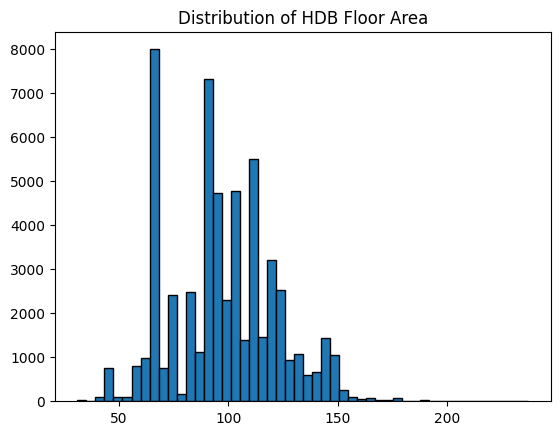

flat_model
Premium Maisonette    1
Terrace               1
Name: count, dtype: int64

In [18]:
# check the floor_area_sqm whether it has outliers
plt.hist(data_copy['floor_area_sqm'], bins=50, edgecolor='black')
plt.title('Distribution of HDB Floor Area')
plt.show()
display(data_copy[data_copy['floor_area_sqm'] > 200]['flat_model'].value_counts())

conclusion: observing the distribution below, The floor area outliers mostly belong to special HDBs 
that are larger than the standard ones. So they might not be outliers from a multivariate perspective.

* for the resale_price column

In [19]:
# using IQR method to detect and remove outliers
Q1 = np.percentile(data['resale_price'], 25, method='midpoint')
Q3 = np.percentile(data['resale_price'], 75, method='midpoint')
IQR = Q3 - Q1 #calculate IQR
print(IQR)

190000.0


In [20]:
#calculate the benches of two sides
upper=Q3+1.5*IQR
upper_array=np.array(data['resale_price']>=upper)
print("Upper Bound:",upper)
print(upper_array.sum())
 
#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(data['resale_price']<=lower)
print("Lower Bound:",lower)
print(lower_array.sum())

Upper Bound: 800000.0
1979
Lower Bound: 40000.0
0


In [21]:
#eliminating the outliers
data = data[(data['resale_price'] >= lower) & (data['resale_price'] <= upper)]

In [23]:
#drop "town" and "address" which are unecessary values
data = data.drop(columns=['town', 'addresses'])

## 1.2.FEATURE SCALING

In [24]:
#before i apply the assumption testing, i've first standardlized the data because the standardlized data is the main data to
#apply to model, so need to test it first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_columns = ['floor_area_sqm','lease_commence_date','remaining_lease','lat','long','distanceWithMrt',
                    'distanceWithRaffles', 'distanceWithGdPri']
scaler.fit(data[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(data[scaled_columns]), index=data.index, columns=scaled_columns)
unscaled_columns = data.drop(scaled_columns, axis=1)

data = pd.concat([unscaled_columns, scaled_columns], axis=1)

In [26]:
data.head(3)

,month,flat_type,storey_range,resale_price,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard,floor_area_sqm,lease_commence_date,remaining_lease,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri
0,2018-01,0,3,250000.0,0,0,0,0,0,1,-2.189207,-1.246874,-1.177124,-0.094986,0.156198,-0.850555,-0.837559,0.726098
1,2018-01,1,0,240000.0,0,0,0,1,0,0,-1.236156,-1.246874,-1.138810,-0.003818,-0.015266,1.154291,-0.709384,-0.646387
2,2018-01,1,0,240000.0,0,0,0,1,0,0,-1.194719,-1.017102,-0.953624,0.154281,0.044620,-0.355212,-0.551599,-0.114856


In [27]:
data.to_csv('E:\singapore\data\preprocessed_data.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_15920\3995278254.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


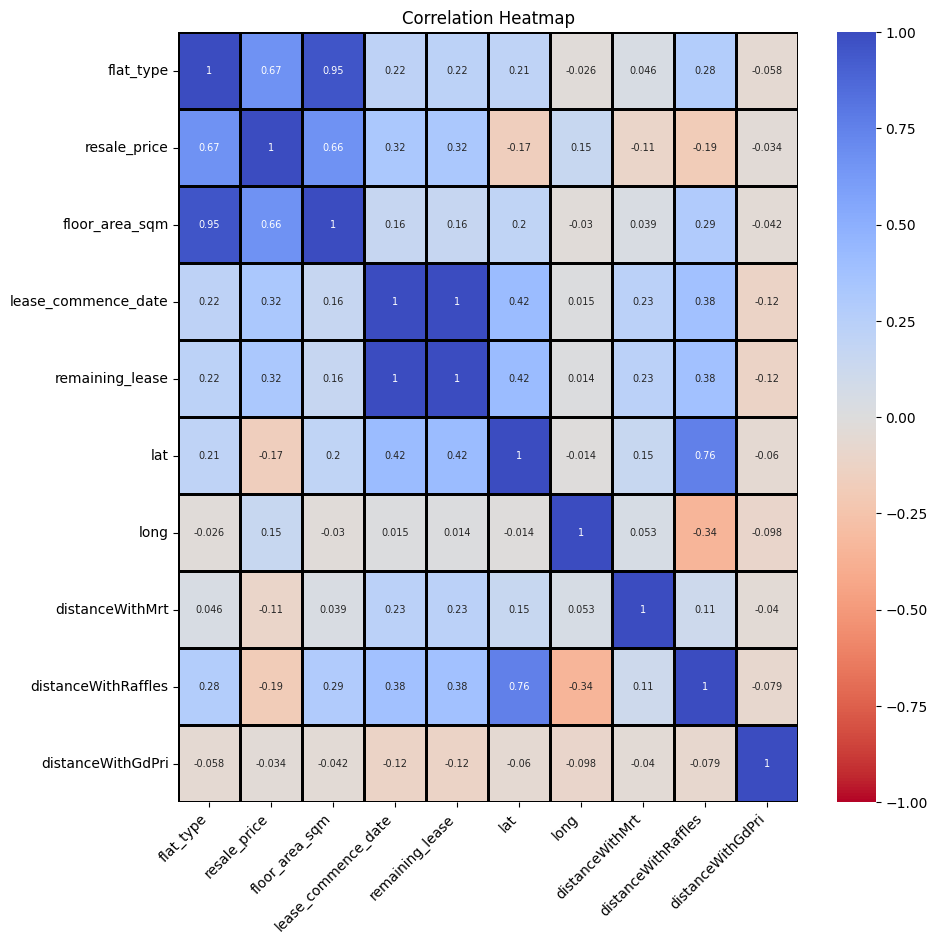

In [25]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [101]:
# use the correlation table for checking if happened Multicollinearity => none of those features have depent on each other

**label encoding for plugging in model**

In [56]:
data.head(1)

,month,town,flat_type,addresses,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard
0,2018-01,ANG MO KIO,0,314 ANG MO KIO AVE 3,3,44.0,1978,59.083333,250000.0,1.366227,103.850086,416.686149,9162.186778,1396.42021,0,0,0,0,0,1


In [57]:
data.info()
# the columns that have continous values: floor_area_sqm, lease_commence_date, remaining_lease, lat, long, distanceWithMrt,
#  distanceWithRaffles, distanceWithGdPri


<class 'pandas.core.frame.DataFrame'>
Index: 57327 entries, 0 to 57384
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   month                 57327 non-null  object 
 1   town                  57327 non-null  object 
 2   flat_type             57327 non-null  int64  
 3   addresses             57327 non-null  object 
 4   storey_range          57327 non-null  int8   
 5   floor_area_sqm        57327 non-null  float64
 6   lease_commence_date   57327 non-null  int64  
 7   remaining_lease       57327 non-null  float64
 8   resale_price          57327 non-null  float64
 9   lat                   57327 non-null  float64
 10  long                  57327 non-null  float64
 11  distanceWithMrt       57327 non-null  float64
 12  distanceWithRaffles   57327 non-null  float64
 13  distanceWithGdPri     57327 non-null  float64
 14  model_Apartment       57327 non-null  int32  
 15  model_Maisonette      57

In [21]:
#before i apply the assumption testing, i've first standardlized the data because the standardlized data is the main data to
#apply to model, so need to test it first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_columns = ['floor_area_sqm','lease_commence_date','remaining_lease','lat','long','distanceWithMrt',
                    'distanceWithRaffles', 'distanceWithGdPri']
scaler.fit(data[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(data[scaled_columns]), index=data.index, columns=scaled_columns)
unscaled_columns = data.drop(scaled_columns, axis=1)

data = pd.concat([unscaled_columns, scaled_columns], axis=1)

In [22]:
data['resale_price'] = data.pop('resale_price')

In [264]:
data.head(3)

,month,flat_type,storey_range,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard,floor_area_sqm,lease_commence_date,remaining_lease,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri,resale_price
0,2018-01,0,3,0,0,0,0,0,1,-2.201704,-1.263416,-1.066514,-0.055000,0.158348,-0.830760,-0.765374,0.713007,250000.0
1,2018-01,1,0,0,0,0,1,0,0,-1.256201,-1.263416,-1.127436,0.034854,-0.015163,1.176661,-0.640786,-0.653785,240000.0
2,2018-01,1,0,0,0,0,1,0,0,-1.215092,-1.034014,-0.978515,0.190674,0.045438,-0.334782,-0.487417,-0.124458,240000.0


In [263]:
data = data.drop(columns=['town', 'addresses'])

**detect and handle outliers using IQR method**

In [276]:
Q1 = np.percentile(data['resale_price'], 25, method='midpoint')
Q3 = np.percentile(data['resale_price'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)

190000.0


In [286]:
upper=Q3+1.5*IQR
upper_array=np.array(data['resale_price']>=upper)
print("Upper Bound:",upper)
print(upper_array.sum())
 
#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(data['resale_price']<=lower)
print("Lower Bound:",lower)
print(lower_array.sum())

Upper Bound: 800000.0
104
Lower Bound: 40000.0
0


In [284]:
data = data[(data['resale_price'] >= lower) & (data['resale_price'] <= upper)]

In [285]:
print(data.shape)

(55452, 18)


In [1]:
data.head(1)

NameError: name 'data' is not defined

**assumption testing**

In [ ]:
lr_df.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

In [223]:
data.to_csv('E:/singapore/data/n.csv', index=False)

FEATURE VISUALIZATION

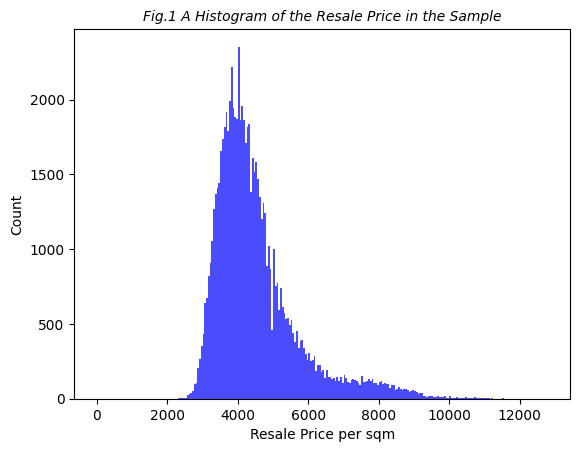

In [12]:
# Filter out rows with NA values in 'resale_pricePersqm'
df_filtered = df.dropna(subset=['resale_pricePersqm'])

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Create the histogram
ax.hist(df_filtered['resale_pricePersqm'], bins=range(0, int(df_filtered['resale_pricePersqm'].max()) + 51, 50), color='blue', alpha=0.7)

# Customize the title and axis labels
ax.set_title('Fig.1 A Histogram of the Resale Price in the Sample', fontsize=10, style='italic')
ax.set_xlabel('Resale Price per sqm')
ax.set_ylabel('Count')

# Show the plot
plt.show()

In [42]:
df_copy.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,resale_pricePersqm
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,232000.0,5272.727273


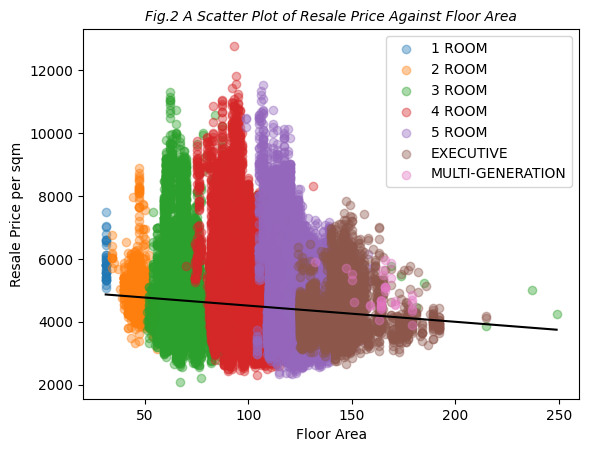

In [59]:
all_filtered = df.dropna(subset=['resale_pricePersqm', 'floor_area_sqm'])

# Create a scatter plot with Matplotlib
fig, ax = plt.subplots()

# Group data by 'flat_type'
groups = all_filtered.groupby('flat_type')

# Create a scatter plot for each 'flat_type' group
for name, group in groups:
    ax.scatter(group['floor_area_sqm'], group['resale_pricePersqm'], label=name, alpha=0.4)

# Add a linear regression line to the entire dataset
slope, intercept, r_value, p_value, std_err = linregress(all_filtered['floor_area_sqm'], all_filtered['resale_pricePersqm'])
line_x = np.array([all_filtered['floor_area_sqm'].min(), all_filtered['floor_area_sqm'].max()])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, color='black')

# Customize the title, axis labels, and legend
ax.set_title('Fig.2 A Scatter Plot of Resale Price Against Floor Area', fontsize=10, style='italic')
ax.set_xlabel('Floor Area')
ax.set_ylabel('Resale Price per sqm')
ax.legend()

# Show the plot
plt.show()

In [ ]:
# after plotting, i saw the most data points are not close to the linear line => correlation is low

In [ ]:
#Higher floors are also positively correlated with resale price per sqm. This is because high-storey HDBs are rare and 
# their supply limited. Majority of the flats are built not exceeding 18 storeys, as can be seen in the transaction volume 
# (white box). I will code it into a categorical variable later.

FEATURE ENGINEERING

In [14]:
geo_data = pd.read_csv('E:\\singapore\\data\\all_with_Drive_Walk_Dis.csv')

In [17]:
geo_data

,Index,month,town,flat_type,address,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,lat,long,Drive_Dis_Downtown,Walk_Dis_Mrt
0,1,2018-01,ANG MO KIO,2 ROOM,314_ANG MO KIO AVE 3,10 TO 12,44.0,Improved,1978,59 years 01 month,250000.0,1.366227,103.850086,12317,462
1,2,2018-01,ANG MO KIO,3 ROOM,109_ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,59 years 07 months,240000.0,1.370097,103.837688,13458,1420
2,3,2018-01,ANG MO KIO,3 ROOM,150_ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,62 years,240000.0,1.376807,103.842018,15227,933
3,4,2018-01,ANG MO KIO,3 ROOM,559_ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1980,61 years,242000.0,1.370998,103.857856,13061,1006
4,5,2018-01,ANG MO KIO,3 ROOM,461_ANG MO KIO AVE 10,10 TO 12,68.0,New Generation,1980,61 years 01 month,255000.0,1.367528,103.857410,13078,850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57381,57382,2020-08,YISHUN,EXECUTIVE,611_YISHUN ST 61,04 TO 06,146.0,Maisonette,1987,66 years 03 months,598000.0,1.420201,103.836153,21926,638
57382,57383,2020-08,YISHUN,EXECUTIVE,643_YISHUN ST 61,01 TO 03,142.0,Apartment,1987,66 years 01 month,510000.0,1.421335,103.837437,21763,924
57383,57384,2020-08,YISHUN,EXECUTIVE,724_YISHUN ST 71,07 TO 09,142.0,Apartment,1986,64 years 11 months,555000.0,1.426475,103.829916,22369,853
57384,57385,2020-08,YISHUN,EXECUTIVE,877_YISHUN ST 81,04 TO 06,145.0,Maisonette,1987,66 years 04 months,639888.0,1.413902,103.835454,21027,647


In [20]:
geo_copy = geo_data.copy()

In [80]:
geo_copy['distanceWithMRT'] = geo_data['Walk_Dis_Mrt']
geo_copy['distanceWithRaffles'] = geo_data['Drive_Dis_Downtown']

In [22]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sg = world[world['name'] == 'Singapore']
print(sg)

C:\Users\HP\AppData\Local\Temp\ipykernel_13728\412403932.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []


In [95]:
geo_data.head(1)

,Index,month,town,flat_type,address,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,lat,long,Drive_Dis_Downtown,Walk_Dis_Mrt
0,1,2018-01,ANG MO KIO,2 ROOM,314_ANG MO KIO AVE 3,10 TO 12,44.0,Improved,1978,59 years 01 month,250000.0,1.366227,103.850086,12317,462


C:\Users\HP\AppData\Local\Temp\ipykernel_13728\3125332917.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


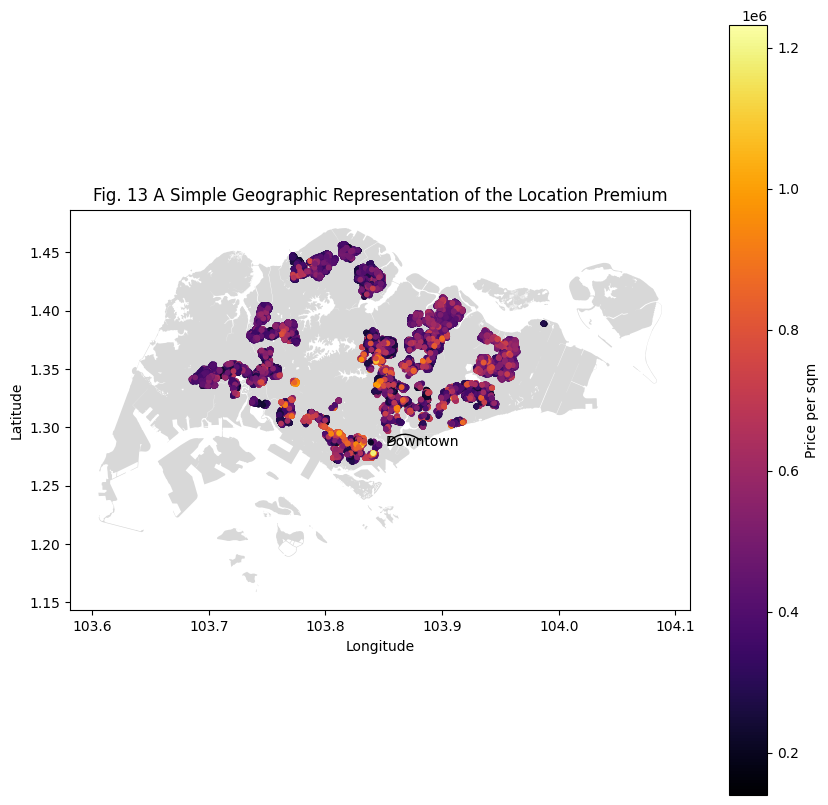

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sg = world[world['name'] == 'Singapore']

sg_gdf = gpd.read_file("E:\\singapore\\data\\singapore-boundary.geojson")

# Assuming you have the 'geodata' GeoDataFrame with 'resale_pricePersqm', 'long', and 'lat' columns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Singapore's boundaries
sg_gdf.plot(ax=ax, color='grey', alpha=0.3)

# Plot the points with color indicating 'resale_pricePersqm'
scatter = plt.scatter(geo_data['long'], geo_data['lat'], c=geo_data['resale_price'], cmap='inferno', s=10)
plt.colorbar(scatter, label='Price per sqm')

# Annotate the location "Downtown"
ax.annotate("Downtown", xy=(103.851463, 1.283933262), xytext=(103.852, 1.284), fontsize=10,
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fig. 13 A Simple Geographic Representation of the Location Premium')

plt.show()

In [27]:


# Assuming you have the 'geodata' GeoDataFrame with 'resale_pricePersqm', 'long', 'lat', and 'address' columns
# Create a base map using OneMapSG tiles
m = folium.Map(location=[1.283933262, 103.851463], zoom_start=10, tiles='https://maps.onemap.sg/v3/Default/{z}/{x}/{y}.png', attr='© <a href="https://www.onemap.sg/main/v2/">OneMapSG</a> contributors')

# Create a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each location
for row in geo_data.itertuples():
    folium.Marker([row.lat, row.long], popup=row.address, icon=folium.DivIcon(html=f'<div>{round(row.resale_price)}</div>')).add_to(marker_cluster)
m.save('leaflet.html')

In [30]:
df_copy.to_csv('E:/singapore/data/copy.csv')

In [30]:
df_copy.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,resale_pricePersqm
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,232000.0,5272.727273


In [32]:
unique_flat_types = df_copy['flat_type'].unique()
print(unique_flat_types)

['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']
